https://www.youtube.com/watch?v=Wqmtf9SA_kk

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [57]:
data = pd.read_csv("nybolig_data.csv")
display(data.head())
display(data.info())

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label
0,https://www.nybolig.dk/villa/3100/arfriisvej/2...,A R Friis Vej 9 3100 Hornbæk,3100,villa,9975000,269,12.0,9,1895,1999.0,D
1,https://www.nybolig.dk/fritidshus/7990/akoldin...,A. Koldings Vej 8 Sillerslev 7990 Øster Assels,7990,fritidsbolig,1495000,96,0.0,4,2008,NaN,NaN
2,https://www.nybolig.dk/villa/6400/aabenraavej/...,Aabenraavej 103 Ragebøl 6400 Sønderborg,6400,villa,1295000,219,0.0,7,1924,NaN,E
3,https://www.nybolig.dk/villa/6100/aabenraavej/...,Aabenraavej 59 6100 Haderslev,6100,villa,2495000,226,35.0,6,1947,2010.0,C
4,https://www.nybolig.dk/villa/9240/aagade/27020...,Aagade 4 Vegger 9240 Nibe,9240,villa,495000,159,59.0,4,1958,NaN,D


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5425 entries, 0 to 5424
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            5425 non-null   object 
 1   address        5425 non-null   object 
 2   postal_code    5425 non-null   int64  
 3   type           5425 non-null   object 
 4   price          5425 non-null   int64  
 5   size           5425 non-null   int64  
 6   basement_size  4528 non-null   float64
 7   rooms          5425 non-null   int64  
 8   year_built     5425 non-null   int64  
 9   year_rebuilt   2049 non-null   float64
 10  energy_label   4789 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 466.3+ KB


None

In [58]:
data

,url,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label
0,https://www.nybolig.dk/villa/3100/arfriisvej/2...,A R Friis Vej 9 3100 Hornbæk,3100,villa,9975000,269,12.0,9,1895,1999.0,D
1,https://www.nybolig.dk/fritidshus/7990/akoldin...,A. Koldings Vej 8 Sillerslev 7990 Øster Assels,7990,fritidsbolig,1495000,96,0.0,4,2008,NaN,NaN
2,https://www.nybolig.dk/villa/6400/aabenraavej/...,Aabenraavej 103 Ragebøl 6400 Sønderborg,6400,villa,1295000,219,0.0,7,1924,NaN,E
3,https://www.nybolig.dk/villa/6100/aabenraavej/...,Aabenraavej 59 6100 Haderslev,6100,villa,2495000,226,35.0,6,1947,2010.0,C
4,https://www.nybolig.dk/villa/9240/aagade/27020...,Aagade 4 Vegger 9240 Nibe,9240,villa,495000,159,59.0,4,1958,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...
5420,https://www.nybolig.dk/villa/8210/oestrevej/25...,Østrevej 5 Hasle 8210 Aarhus V,8210,villa,5248000,111,90.0,6,1928,2012.0,C
5421,https://www.nybolig.dk/villa/8930/oestrupvej/2...,Østrupvej 11 Albæk 8930 Randers NØ,8930,villa,995000,231,0.0,6,1850,2006.0,E
5422,https://www.nybolig.dk/villa/7130/oestrupvej/2...,Østrupvej 26 Glud 7130 Juelsminde,7130,villa,895000,83,6.0,4,1952,NaN,D
5423,https://www.nybolig.dk/villa/7130/oestrupvej/2...,Østrupvej 49 Glud 7130 Juelsminde,7130,villa,3995000,241,0.0,7,1986,2008.0,A2010


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5425 entries, 0 to 5424
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url            5425 non-null   object 
 1   address        5425 non-null   object 
 2   postal_code    5425 non-null   int64  
 3   type           5425 non-null   object 
 4   price          5425 non-null   int64  
 5   size           5425 non-null   int64  
 6   basement_size  4528 non-null   float64
 7   rooms          5425 non-null   int64  
 8   year_built     5425 non-null   int64  
 9   year_rebuilt   2049 non-null   float64
 10  energy_label   4789 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 466.3+ KB


In [60]:
from sklearn.model_selection import train_test_split
X = data.drop(['price'], axis = 1)
y = data['price']

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'basement_size'}>,
        <Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>],
       [<Axes: title={'center': 'year_rebuilt'}>, <Axes: >, <Axes: >]],
      dtype=object)

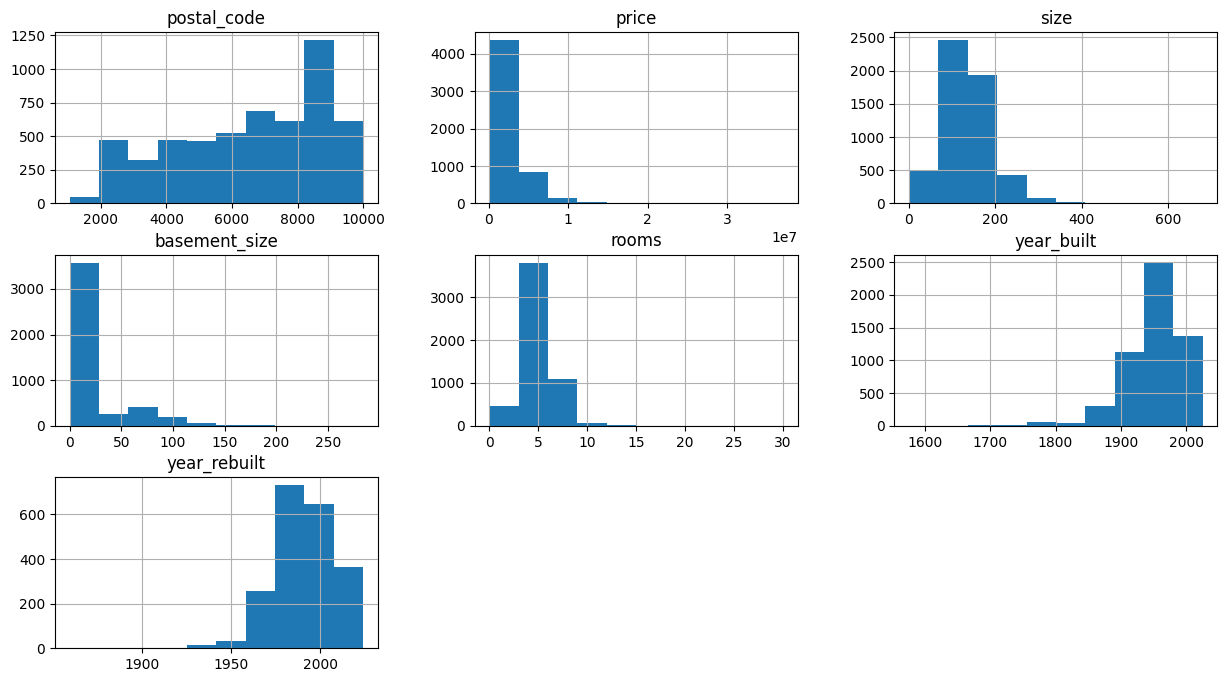

In [61]:
data.hist(figsize = (15, 8))

<Axes: >

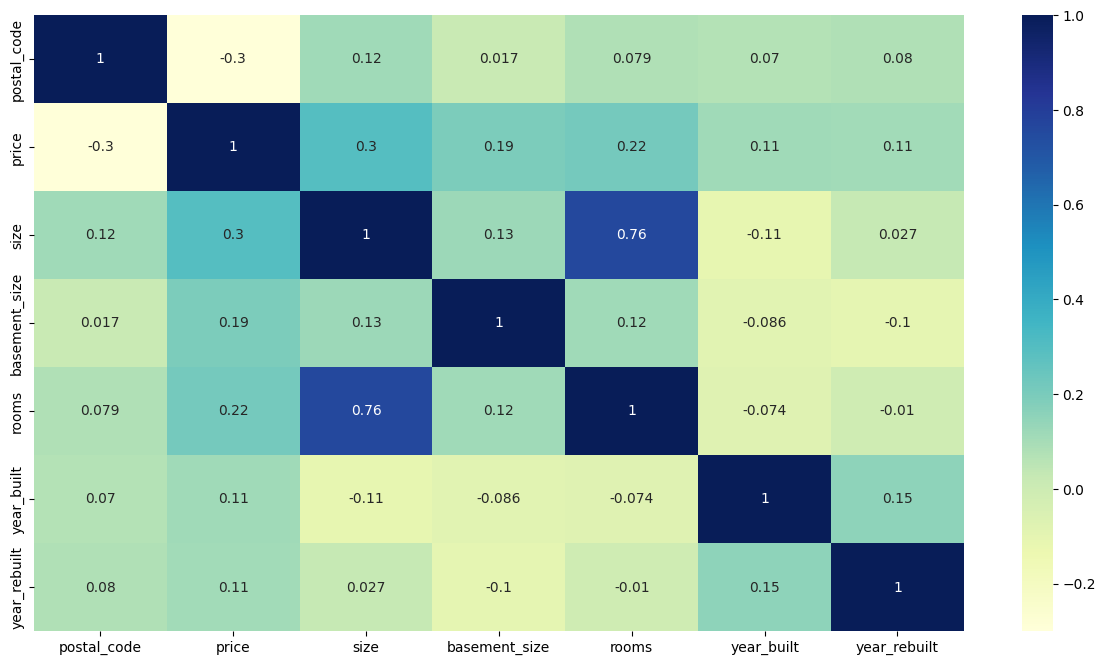

In [62]:
plt.figure(figsize = (15, 8))
sns.heatmap(data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

# Preprocessing

In [63]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [64]:
def preprocess_data(data, transformations: bool = False, encoding: str = 'normal', drop_low_corr: bool = False):
    # Fill the missing values
    data['year_rebuilt'] = data['year_rebuilt'].where(~data['year_rebuilt'].isna(), data['year_built']).astype(int)
    data['basement_size'] = data["basement_size"].fillna(0)
    # Drop the columns that are not needed
    data = data.drop(['url', 'address'], axis = 1)

    # Apply the transformations
    if transformations:
        data['postal_code'] = (data['postal_code'] + 1) ** 2
        data['rooms'] = np.log(data['rooms'] + 1)
        data['size'] = np.log(data['size'] + 1)
        data['basement_size'] = np.log(data['basement_size'] + 1)
        data['year_built'] = (data['year_built'] + 1) ** 2
        data['year_rebuilt'] = (data['year_rebuilt'] + 1) ** 2

    #if scaling: 
    #   scaler = StandardScaler()
    #   data = pd.DataFrame(scaler.fit_transform(data), columns = x_data.columns)

    # Encode the categorical variables
    if encoding == 'normal':
        data['type'] = data['type'].astype('category').cat.codes
        data['energy_label'] = data['energy_label'].astype('category').cat.codes
        #Another way of doing it 
        #data['type'] = data().LabelEncoder().fit_transform(data['type'])
        #data['energy_label'] = data().LabelEncoder.fit_transform(data['energy_label'])
    elif encoding == 'onehot':
        data = pd.get_dummies(data, columns = ['type', 'energy_label'], drop_first = True, dtype=int)
    else:
        raise ValueError("The encoding parameter must be either 'normal' or 'onehot'")

    # Drop the columns that have low correlation with the target variable
    if drop_low_corr:
        for column in data.select_dtypes(include = np.number).columns:
            if abs(data[column].corr(data['price'])) < 0.1:
                data = data.drop(column, axis = 1)
        
    return data

In [65]:
preprocessed_data = preprocess_data(data, transformations = False, encoding = 'onehot', drop_low_corr = True)

array([[<Axes: title={'center': 'postal_code'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'size'}>],
       [<Axes: title={'center': 'basement_size'}>,
        <Axes: title={'center': 'rooms'}>,
        <Axes: title={'center': 'year_built'}>],
       [<Axes: title={'center': 'year_rebuilt'}>,
        <Axes: title={'center': 'energy_label_A2010'}>,
        <Axes: title={'center': 'energy_label_A2015'}>]], dtype=object)

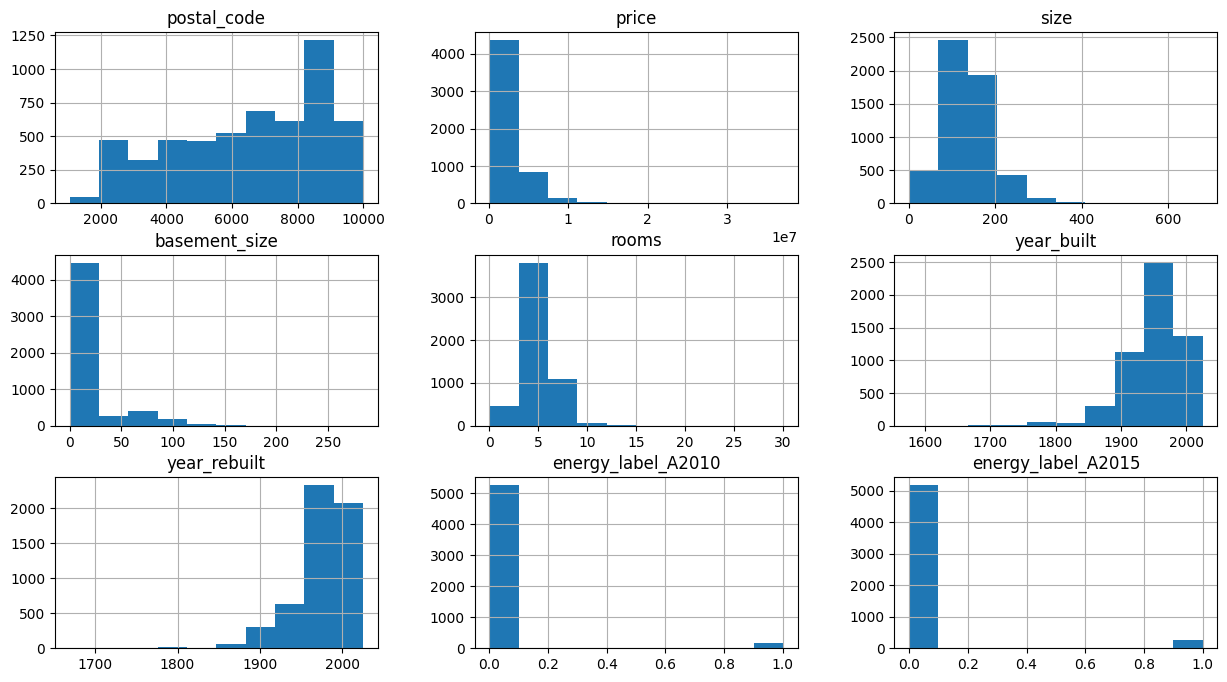

In [66]:
preprocessed_data.hist(figsize = (15, 8))

<Axes: >

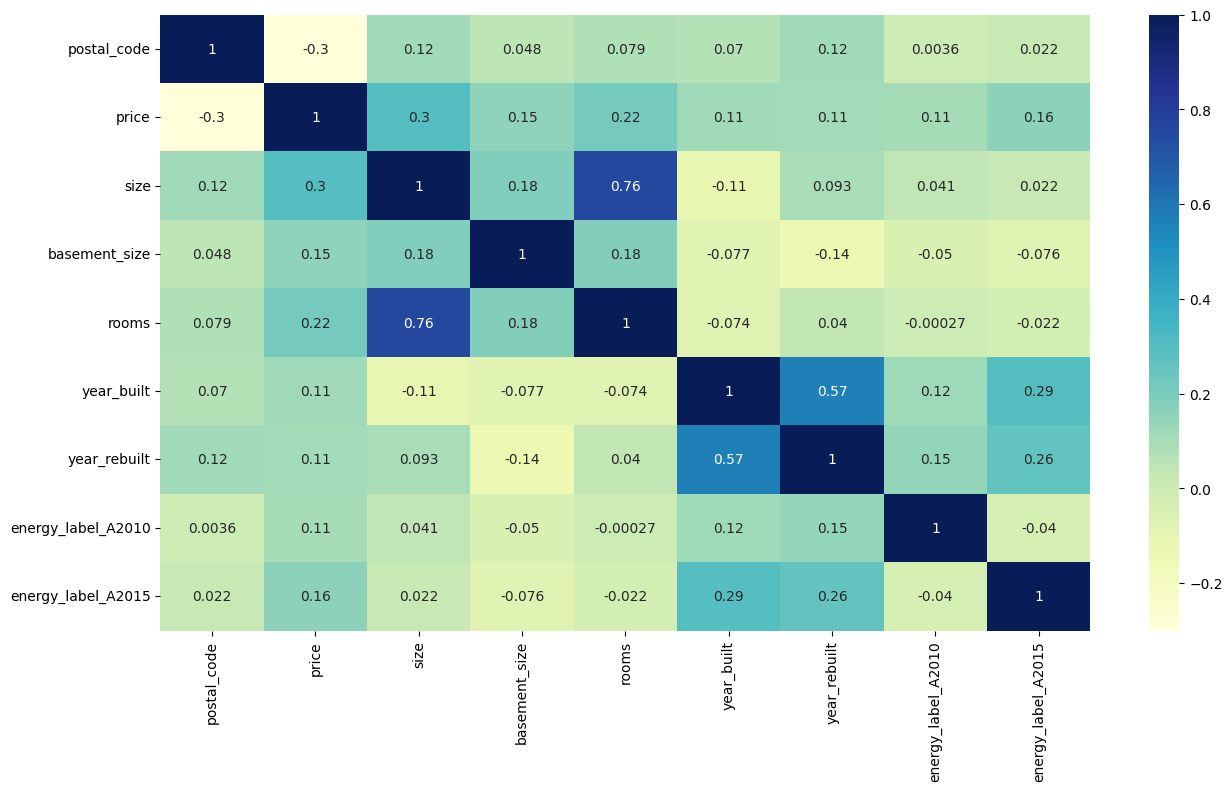

In [67]:
plt.figure(figsize = (15, 8))
sns.heatmap(preprocessed_data.select_dtypes(include = np.number).corr(), annot = True, cmap = "YlGnBu")

In [68]:
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data.drop(['price'], axis = 1), preprocessed_data['price'], test_size = 0.2, random_state = 0)
display(X_train)
display(y_train)


,postal_code,size,basement_size,rooms,year_built,year_rebuilt,energy_label_A2010,energy_label_A2015
4052,9000,89,0.0,3,1963,1992,0,0
5140,5600,144,94.0,4,1948,1948,0,0
2624,8600,128,0.0,3,1902,2018,0,0
538,4000,113,0.0,4,2008,2008,0,0
4880,4200,98,0.0,5,1907,1907,0,0
...,...,...,...,...,...,...,...,...
4931,5492,220,0.0,5,1984,1993,0,0
3264,3480,65,0.0,3,1965,1965,0,0
1653,8260,100,64.0,4,1912,1912,0,0
2607,9000,67,0.0,3,1895,1895,0,0


4052    1395000
5140     695000
2624    3695000
538     3195000
4880     795000
         ...   
4931    1795000
3264    1995000
1653    7350000
2607    1798000
2732    2295000
Name: price, Length: 4340, dtype: int64

# Regression 

## Lasso and Ridge Regression 

In [69]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
warnings.simplefilter(action='ignore', category=FutureWarning)
np.set_printoptions(suppress=True)

Scores [0.21064232 0.26202921 0.22934929 0.29513995 0.29249618]
Test score:  0.31525153712422516

Coefficients: 
postal_code: -369.8131228701834
size: 14507.99022700932
basement_size: 10338.870863625865
rooms: -73621.01834178575
year_built: 5925.138052306058
year_rebuilt: 2503.569588579885
energy_label_A2010: 1098689.6458856894
energy_label_A2015: 1356145.0059673507

Intercept:  -13351513.570274403

Evaluation
Mean squared error:  3875785026148.022
Mean absolute error:  1316088.6453838062
R2 score:  0.31525153712422516


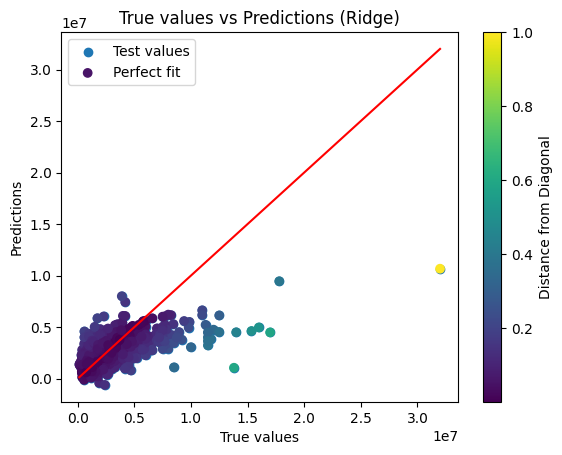

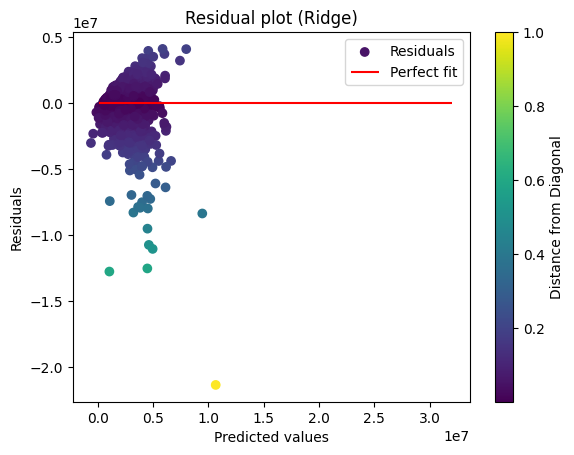

Scores [0.20997111 0.26236831 0.22963688 0.29571238 0.2927484 ]
Test score:  0.31580337807317604

Coefficients: 
postal_code: -369.5641177383541
size: 14447.336343342638
basement_size: 10379.969880658757
rooms: -72045.47741113548
year_built: 5812.146563646298
year_rebuilt: 2400.1184997508235
energy_label_A2010: 1197123.311427366
energy_label_A2015: 1440408.5276650519

Intercept:  -12934101.581424536

Evaluation
Mean squared error:  3872661518754.1147
Mean absolute error:  1315910.3623658642
R2 score:  0.31580337807317604


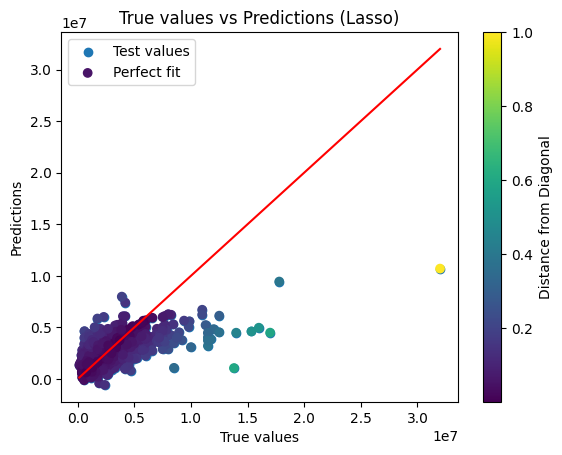

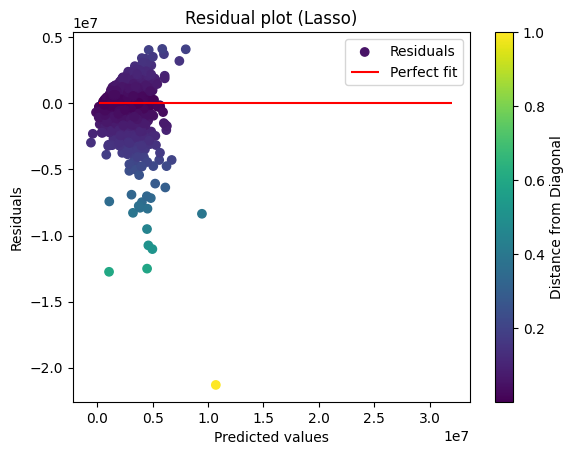

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def regression(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    score = cross_val_score(model, x_train, y_train, cv=5)
    print("Scores", score)
    print("Test score: ", model.score(x_test, y_test))
    print("\nCoefficients: ")
    for feature, coef in zip(x_train.columns, model.coef_):
        print(f"{feature}: {coef}")
    print("\nIntercept: ", model.intercept_)

    # Predicting the test set results
    y_pred = model.predict(x_test)
    
    #Evaluating the model
    print("\nEvaluation")
    print("Mean squared error: ", mean_squared_error(y_test, y_pred))
    print("Mean absolute error: ", mean_absolute_error(y_test, y_pred))
    print("R2 score: ", r2_score(y_test, y_pred))


    #Plotting the test set results
    plt.scatter(y_test, y_pred)

    # Calculate residuals
    residuals = y_pred - y_test

    # Calculate distances from the perfect fit line
    distances = np.abs(y_test - y_pred)

    # Define color gradient based on distances
    colors = distances / np.max(distances)  # Normalize distances to range [0, 1]
    # colors = plt.cm.RdYlGn_r(colors)  # Reverse the colormap: green (furthest), red (closest)

    # Plot true values vs predictions with color gradient
    plt.scatter(y_test, y_pred, c=colors)
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    # Plot the perfect fit line
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
    # Name the perfect fit line
    plt.legend(['Test values', 'Perfect fit'])
    plt.title(f'True values vs Predictions ({model.__class__.__name__})')
    plt.colorbar(label='Distance from Diagonal')
    plt.show()

    # Plot residuals
    plt.scatter(y_pred, residuals, c=colors)
    plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='r')
    plt.title(f'Residual plot ({model.__class__.__name__})')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.colorbar(label='Distance from Diagonal')
    plt.legend(['Residuals', 'Perfect fit'])
    plt.show()


#linear_model_ = linear_model.LinearRegression()
lasso_model = linear_model.Lasso(alpha = 10)
ridge_model = linear_model.Ridge(alpha = 10)
regression(ridge_model, X_train, y_train, X_test, y_test)
regression(lasso_model, X_train, y_train, X_test, y_test)

For this results, we have the following: 
  1. Lasso Scores: These are cross-validation scores obtained using 5-fold cross-validation. They represent the R-squared values achieved by the Lasso model on different folds of the training data. Each score corresponds to one fold.
  2. Lasso test score: This is the R-squared score of the model on the held-out test set.
  3. Lasso coefficients: These are the weights assigned to each feature by the Lasso model. 
  4. Lasso intercept: This is the bias term of the model.

# Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(random_state = 0)
forest.fit(X_train, y_train)

0.6865718335963573

R2 score:  0.6865718335963573
Mean squared error:  1774053188843.2302
Mean absolute error:  803198.5503308744


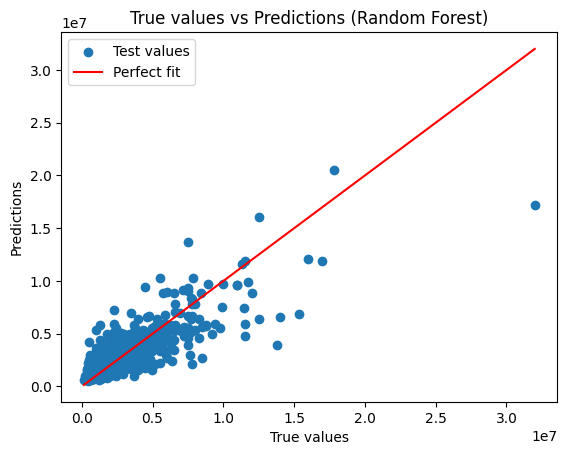

In [103]:
print("R2 score: ", forest.score(X_test, y_test))
print("Mean squared error: ", mean_squared_error(y_test, forest.predict(X_test)))
print("Mean absolute error: ", mean_absolute_error(y_test, forest.predict(X_test)))

# Plotting the test set results
plt.scatter(y_test, forest.predict(X_test))
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('True values vs Predictions (Random Forest)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
plt.legend(['Test values', 'Perfect fit'])
plt.show()

## Hyperparameter Tuning

In [90]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [500, 1000, 1500],
#     'max_features': [3, 4, 5],
# }

# grid_search = GridSearchCV(forest, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, y_train)
# best_forest = grid_search.best_estimator_
# best_forest

In [92]:
# best_forest.score(X_test, y_test)

0.6790672909572453

Best parameters:  {'max_features': 4, 'n_estimators': 1000}
R2 score:  0.6790672909572453
Mean squared error:  1816530091772.8198
Mean absolute error:  821926.2705992335


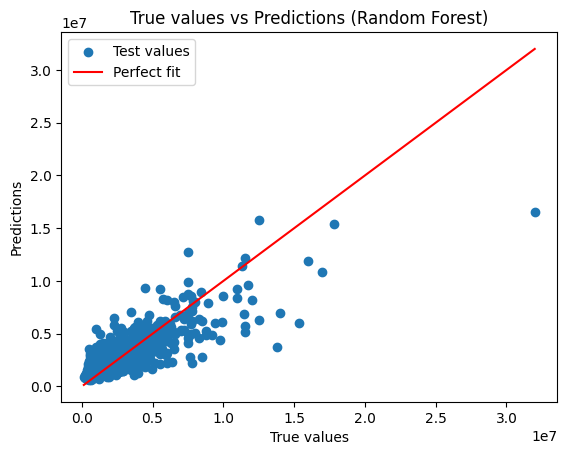

In [99]:
# print("Best parameters: ", grid_search.best_params_)
# print("R2 score: ", best_forest.score(X_test, y_test))
# print("Mean squared error: ", mean_squared_error(y_test, best_forest.predict(X_test)))
# print("Mean absolute error: ", mean_absolute_error(y_test, best_forest.predict(X_test)))

# # Plotting the test set results
# plt.scatter(y_test, best_forest.predict(X_test))
# plt.xlabel('True values')
# plt.ylabel('Predictions')
# plt.title('True values vs Predictions (Random Forest)')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
# plt.legend(['Test values', 'Perfect fit'])
# plt.show()

# Extreme Gradient Boosting 

In [93]:
import xgboost as xgb

R2 score:  0.7256931536862526
Mean squared error:  1552620305342.0847
Mean absolute error:  771111.1192684332


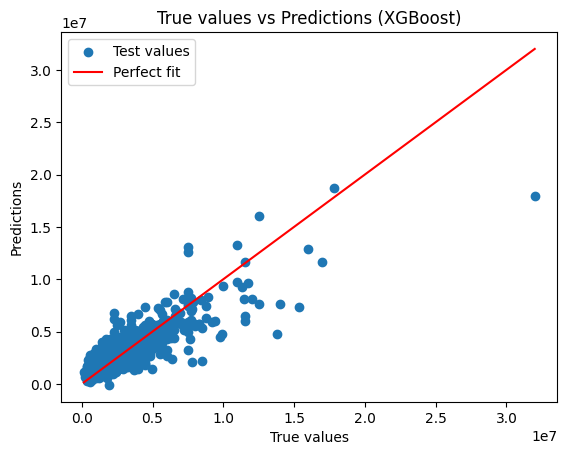

In [94]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 300, learning_rate = 0.1, max_depth = 3)
xgb_model.fit(X_train, y_train)
pred = xgb_model.predict(X_test)
print("R2 score: ", r2_score(y_test, pred))
print("Mean squared error: ", mean_squared_error(y_test, pred))
print("Mean absolute error: ", mean_absolute_error(y_test, pred))
#Plot the true values vs the predicted values
plt.scatter(y_test, pred)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('True values vs Predictions (XGBoost)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='r')
plt.legend(['Test values', 'Perfect fit'])
plt.show()


